<a href="https://colab.research.google.com/github/lfnd0/Machine_Learning/blob/master/ML_Atividade_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede neural utilizando dados sobre câncer de próstata
> Dataset: [Prostate cancer](https://www.kaggle.com/sajidsaifi/prostate-cancer)

## 1. Leitura dos dados

In [56]:
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
data = pd.read_csv('/content/drive/My Drive/Machine_Learning/Datasets/Atividade_3/ca_prostata.csv')
data.head()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059


## 2. Limpeza e organização dos dados

### 2.1 Limpeza dos dados

#### 2.1.1 Remoção da coluna 'id'

In [8]:
data = data.dropna()
data = data.drop(columns = ['id'])
data.head()

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,M,23,12,151,954,0.143,0.278,0.242,0.079
1,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,M,14,16,78,386,0.070,0.284,0.260,0.097
4,M,9,19,135,1297,0.141,0.133,0.181,0.059


#### 2.1.2 Mudança dos valores 'B' e 'M' para '0' e '1'

In [9]:
data['diagnosis_result'] = data['diagnosis_result'].replace(['B', 'M'], [0, 1])
data.head()

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,23,12,151,954,0.143,0.278,0.242,0.079
1,0,9,13,133,1326,0.143,0.079,0.181,0.057
2,1,21,27,130,1203,0.125,0.160,0.207,0.060
3,1,14,16,78,386,0.070,0.284,0.260,0.097
4,1,9,19,135,1297,0.141,0.133,0.181,0.059


### 2.2 Re-escala dos dados usando máximo e mínimo

In [21]:
data = (data - data.min()) / (data.max() - data.min())
data.head()

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1.0,0.8750,0.0625,0.825000,0.448687,1.000000,0.781759,0.633136,0.590909
1,0.0,0.0000,0.1250,0.675000,0.670644,1.000000,0.133550,0.272189,0.090909
2,1.0,0.7500,1.0000,0.650000,0.597255,0.753425,0.397394,0.426036,0.159091
3,1.0,0.3125,0.3125,0.216667,0.109785,0.000000,0.801303,0.739645,1.000000
4,1.0,0.0000,0.5000,0.691667,0.653341,0.972603,0.309446,0.272189,0.136364


### 2.3 Divisão dos dados

#### 2.3.1 Atributos de classe

Os atributos de classe para este dataset são:
*   B (*benign*) com valor 0.0
*   M (*malign*) com valor 1.0

In [22]:
y = data.diagnosis_result
y.head()

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: diagnosis_result, dtype: float64

#### 2.3.2 Atributos descritores

Os atributos descritores para este dataset são:
*    *radius*
*    *texture*
*    *perimeter*
*    *area*
*    *smoothness*
*    *compactness*
*    *symmetry*
*    *fractal_dimension*

In [23]:
x = data.iloc[:, 1:]
x.head()

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,0.8750,0.0625,0.825000,0.448687,1.000000,0.781759,0.633136,0.590909
1,0.0000,0.1250,0.675000,0.670644,1.000000,0.133550,0.272189,0.090909
2,0.7500,1.0000,0.650000,0.597255,0.753425,0.397394,0.426036,0.159091
3,0.3125,0.3125,0.216667,0.109785,0.000000,0.801303,0.739645,1.000000
4,0.0000,0.5000,0.691667,0.653341,0.972603,0.309446,0.272189,0.136364


#### 2.3.3 Conjunto de treino e conjunto de teste

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =  0.2)

##### Conjunto de treino para os atributos de classe

In [25]:
y_train.head()

28    1.0
30    1.0
62    1.0
82    1.0
55    0.0
Name: diagnosis_result, dtype: float64

##### Conjunto de treino para os atributos descritores

In [26]:
x_train.head()

,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
28,0.3750,0.2500,0.416667,0.316229,0.520548,0.429967,0.343195,0.272727
30,0.1250,0.6875,0.608333,0.528640,0.493151,0.491857,0.491124,0.204545
62,0.1875,0.6875,0.366667,0.264916,0.479452,0.530945,0.355030,0.454545
82,0.0625,0.2500,1.000000,1.000000,0.493151,0.745928,0.284024,0.340909
55,0.5625,0.1250,0.175000,0.123508,0.342466,0.055375,0.337278,0.136364


## 3. Treinamento e testes

### 3.1 Rede neural *multi-layer perceptron* (MLP)

#### 3.1.1 Definição do modelo

In [27]:
mlp_cls = MLPClassifier(hidden_layer_sizes=(100), activation='logistic', max_iter=1000)

#### 3.1.2 Treinamento do modelo

In [28]:
mlp_cls.fit(x_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### 3.1.3 Classificação utilizando o modelo

In [29]:
rating = mlp_cls.predict(x_test)
rating

array([1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 1., 1.])

#### 3.1.4 Avaliando os resultados do modelo

##### Acurácia

A taxa de acertos do classificador é de 80%.

In [30]:
round(accuracy_score(y_test, rating), 2)

0.8

##### Precisão

A taxa de precisão do classificador é de 77%.

In [31]:
round(precision_score(y_test, rating), 2)

0.77

##### *Recall*

O *recall* (taxa de instâncias positivas classificadas pelo modelo corretamente) é de 91%.

In [32]:
round(recall_score(y_test, rating), 2)

0.91

##### *F1*-*score*

A taxa do *F1*-*score* é de 83%.

In [33]:
round(f1_score(y_test, rating), 2)

0.83

##### Curva ROC

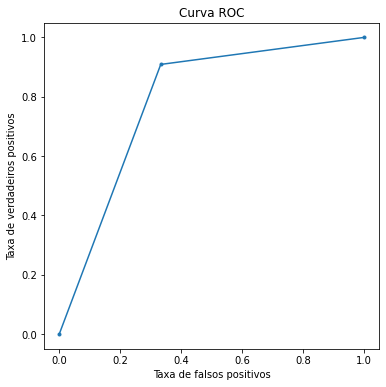

In [46]:
plt.figure(figsize = (6, 6))
fpr, tpr, _ = roc_curve(y_test, rating)
plt.plot(fpr, tpr, marker='.')
plt.title('Curva ROC')
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.show()

##### AUC

A taxa da AUC é de 79%.

In [47]:
round(roc_auc_score(y_test, rating), 2)

0.79

##### Validação cruzada

In [48]:
cross_vld = cross_val_score(mlp_cls, x, y, cv=10)
cross_vld

array([0.7, 0.8, 1. , 1. , 0.9, 0.6, 0.8, 0.8, 0.8, 0.6])

In [60]:
round(cross_vld.mean(), 2), round(cross_vld.std(), 2)

(0.8, 0.13)

#### 3.1.5 Otimização de parâmetros

##### *Random search*

In [51]:
param_grid = [{'hidden_layer_sizes': [(10),(50),(100),(50,10),(100,50)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'max_iter': [500,1000,2000]}]
mlp_rscv = RandomizedSearchCV(MLPClassifier(), param_grid, cv=5, scoring='accuracy')
mlp_rscv.fit(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarnin

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                           verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{

In [54]:
print(f'Melhores parâmetros para Random search: {mlp_rscv.best_params_}')
print(f'Taxa: {round(mlp_rscv.best_score_, 3)}')

Melhores parâmetros: {'solver': 'sgd', 'max_iter': 1000, 'hidden_layer_sizes': 50, 'activation': 'identity'}
0.85


##### *Grid search*

In [57]:
mlp_gscv = GridSearchCV(MLPClassifier(), param_grid, cv=5, scoring='accuracy')
mlp_gscv.fit(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'activation': [

In [61]:
print(f'Melhores parâmetros para Grid search: {mlp_gscv.best_params_}')
print(f'Taxa: {round(mlp_gscv.best_score_, 3)}')

Melhores parâmetros para Grid search: {'activation': 'tanh', 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'adam'}
Taxa: 0.87


## 4. Considerações

*    Diante da natureza do dataset e das métricas para análise do classificador, o valor obtido pela rede neural no *recall* foi de 91%, um valor que pode ser considerado muito bom (Subseção 3.1.4). Tendo em vista que nesta métrica, leva-se em consideração a taxa de verdadeiros positivos e que são classificados pelo modelo de forma correta.
*    No entanto, a taxa de verdadeiros positivos foi de 97% e pode ser verificada a partir da área sob a curva - AUC - (Subseção 3.1.4).
*   Utilizando o método de validação cruzada pôde-se observar uma taxa um pouco menor em relação a média de acertos durante a classificação, sendo de 80%  (Subseção 3.1.4).
*    Sobre a otimização de parâmetros, observa-se que na *Random search* a melhor configuração do modelo para o resolvedor é 'sgd', a quantidade máxima de iterações é igual a 1000, o número de camadas escondidas são 50 e a função de ativação é a 'identity', com uma taxa de acertos igual a 85% (Subseção 3.1.5).
*    Por fim, para a otimização de parâmetros com a *Grid search* a melhor configuração encontrada para a função de ativação é a 'tanh', com o número máximo de neurônios na camada escodida igual a 10, o número máximo de iterações igual a 500 e o resolvedor 'adam', atigindo uma taxa de acertos de 87% (Subseção 3.1.5).